# Beta-Variational Autoencoder Experiments

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from PIL import Image
import os

import numpy as np
import matplotlib.pyplot as plt

import glob
import os
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

/Users/princejavier/anaconda3/envs/book/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/princejavier/anaconda3/envs/book/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/princejavier/anaconda3/envs/book/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/princejavier/anaconda3/envs/book/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device='cpu'

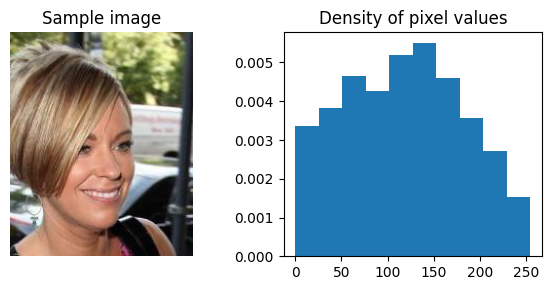

In [3]:
data_path = "/Users/princejavier/Downloads/archive/img_align_celeba/img_align_celeba"
image_paths = glob.glob(os.path.join(data_path, "*.jpg"))
img = plt.imread(image_paths[0])

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(img)
ax[0].set_axis_off()
ax[0].set_title("Sample image")

ax[1].hist(img.flatten(), density=True)
ax[1].set_title("Density of pixel values")

plt.tight_layout()
plt.show()

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

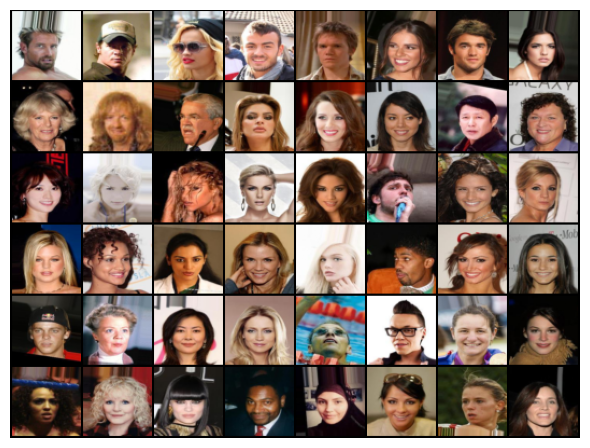

In [ ]:
def imshow(img):
    npimg = img.detach().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [140]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Architecture based on B-VAE paper by Higgins et al, (ICLR, 2017)
        # ------------------------
        self.encoder = nn.Sequential(*[
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),

            # flatten for linear layer
            nn.Flatten(1, -1),
            nn.Linear(in_features=1024, out_features=64), # 32 mu, 32 var
        ])

        self.decoder = nn.Sequential(*[
            # Start with the linear layers
            nn.Linear(in_features=32, out_features=1024),
            nn.ReLU(inplace=True),
            
            # Reshape from flat vector to feature map
            nn.Unflatten(1, (64, 4, 4)),
            
            # Transposed convolutions
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, padding=1, stride=2),
            
        ])

        # apply weights       
        self.apply(self._init_weights)

    def z_sample(self, mu, var):

        # make sure sigma is (+)
        sigma = var ** 0.5

        # generate eps, reparam trick
        mean, std = (0, 1)
        eps = torch.normal(mean, std, size=(32,)).to(device) # just 1 sample needed since SGD is noisy anyway!

        # generate z var with reparam trick
        z = mu + sigma * eps

        return z

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        enc_out = self.encoder(x)
        mu = enc_out[:, :32]
        raw_var = enc_out[:, 32:]
        var = torch.exp(raw_var).to(device)
        log_var = torch.log(var)

        z = self.z_sample(mu, var)
        y = self.decoder(z) # reconstruction
        
        return y, mu, log_var

In [232]:
# Define the ELBO loss function
Beta = 1
def elbo_loss(recon_x, x, mu, log_var):
    # negative likelihood = neg SUM ln(p(x|z,w)) --> decoder
    # basically becomes MSE for MLE of continuous regression with assumed Gaussian error
    # can be interpreted as "reconstruction loss"
    neg_log_likelihood = nn.functional.mse_loss(recon_x.view(-1), x.view(-1), reduction='sum')

    # KL(q||p) term in ELBO Lowerbound, q = posterior from encoder, p = Gaussian prior
    # log_var.exp() is basically var
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) * Beta

    # note this formulation is negative Lowerbound (ELBO), because we want to minimize this instead of maximize
    return neg_log_likelihood + kl_div

In [233]:
# var = 0.5
# logvar = np.log(var)
# mu = -10
# -0.5 * np.sum(1 + logvar - mu**2 - var)
# torch.from_numpy(np.array([logvar])).exp()

In [234]:
batch_size = 64
num_workers = 1

# Create the dataset
dataset = CustomImageDataset(image_paths=image_paths, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

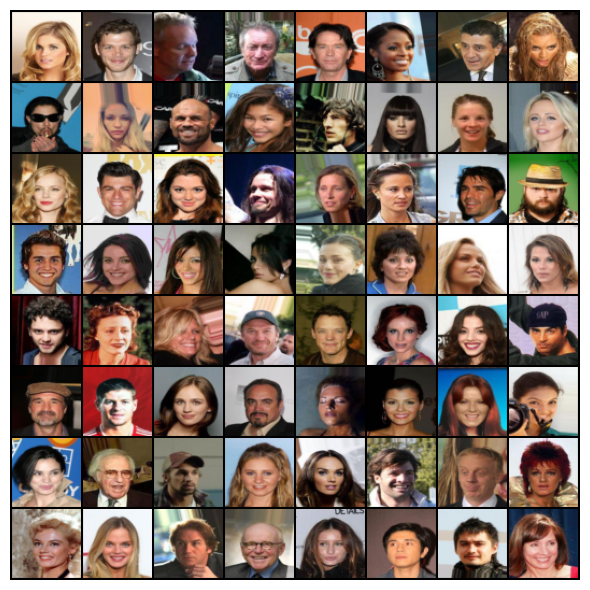

In [235]:
# get some random training images
dataiter = iter(dataloader)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [236]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

vae(next(dataiter))[0].shape

torch.Size([64, 3, 64, 64])

In [239]:
# Training loop
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = elbo_loss(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}")

    print(f"====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}")

# Run the training
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/202599 (0%)]	Loss: 668.571899


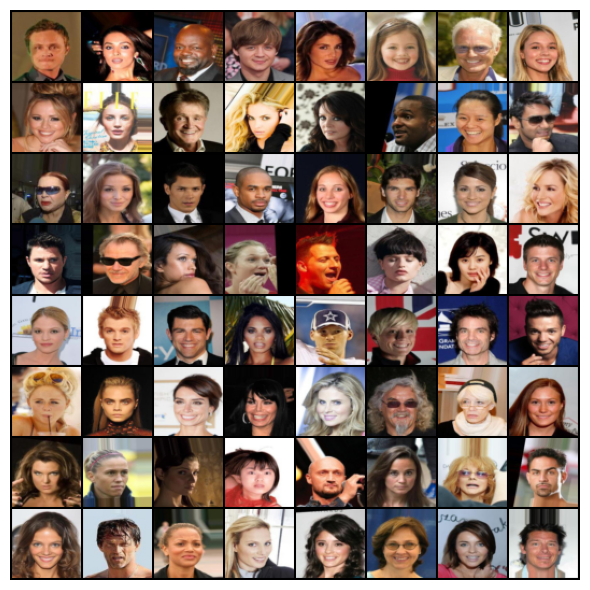

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


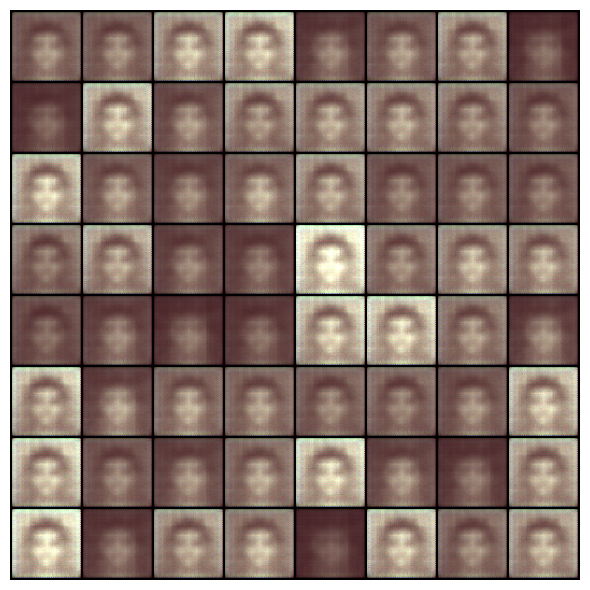

In [238]:
out = vae(next(dataiter))[0]
imshow(torchvision.utils.make_grid(next(dataiter)))
imshow(torchvision.utils.make_grid(out));

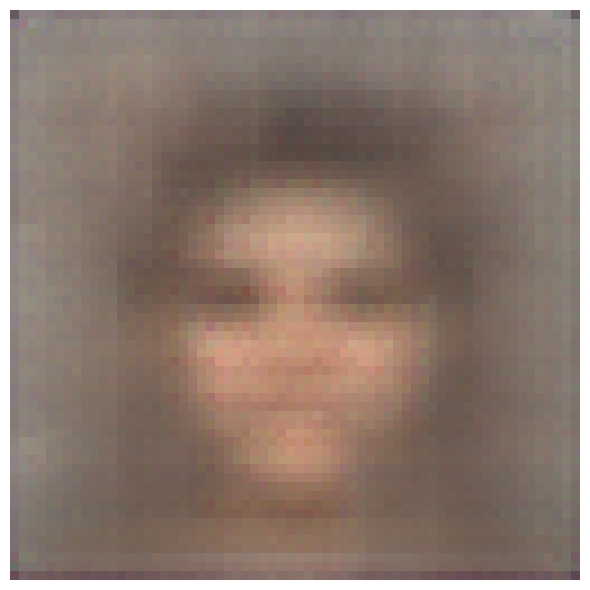

In [229]:
# generate some random z
z = vae.z_sample(mu = torch.rand(32), var=torch.rand(32)).view(1, -1)
imshow(vae.decoder(z)[0])